# Project Overview: Comparing Classifiers for Bank Marketing Campaigns

The goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  

### About the Dataset
Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of 17 marketing campaigns conducted between May 2008 and November 2010, totaling 79,354 contacts.
.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.

In [37]:
import pandas as pd
import numpy as np

# data viz
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight") 

# pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# modeling
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import time

# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

print("All modules loaded")

All modules loaded


In [38]:
# loading the data
url = '/Users/oaxana/Documents/Berkeley-AI/000_Berkeley/Module-17-Practical/bank-additional-full.csv'
df = pd.read_csv(url, sep = ';', na_values = "unknown")

In [39]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [40]:
df.shape

(41188, 21)

In [41]:
df.y.value_counts(normalize=True).round(2)

y
no     0.89
yes    0.11
Name: proportion, dtype: float64

In [42]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [43]:
df['housing'].value_counts()

housing
yes    21576
no     18622
Name: count, dtype: int64

In [44]:
df['month'].value_counts()

month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: count, dtype: int64

### Understanding the Features


Below is a list of features and their descriptions

```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Business Objective

The Portuguese bank seeks to enhance the effectiveness of its direct marketing campaigns for bank products conducted over the telephone. The primary objective is to develop a predictive model that can classify whether a client will subscribe to a long-term deposit product. This classification task will involve comparing the performance of different classification algorithms (k-nearest neighbors, logistic regression, decision trees, and support vector machines) to determine which model best predicts client subscription. Additionally, the objective is to identify the most predictive features influencing the classification outcome.

### Data Cleanup and EDA



In [45]:
# converting Y into numerical
df['y'] = df['y'].replace({"yes":1, "no" :0})

In [46]:
# checking target variable counts
df['y'].value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

In [47]:
# checking for duplicates
df.duplicated().sum()

np.int64(12)

In [48]:
# removing duplicates
df = df.drop_duplicates()

In [51]:
# describing numerical features
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870,0.112663
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364,0.316184
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


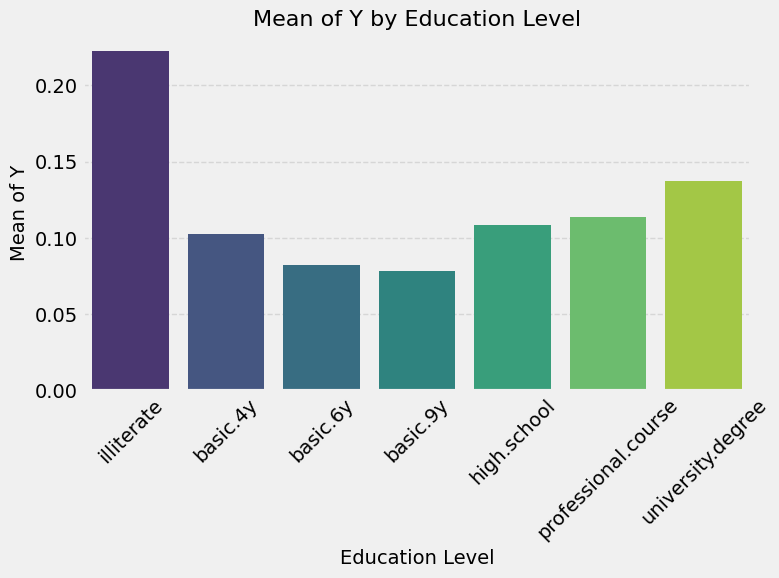

In [78]:
# Group by 'education' and calculate the mean of 'y'
education_means = df.groupby('education')['y'].mean().reset_index()

# Sort the 'education' categories 
education_order = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
education_means['education'] = pd.Categorical(education_means['education'], categories=education_order, ordered=True)
education_means = education_means.sort_values('education')

# Create bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='education', y='y', data=education_means, palette='viridis')
plt.title('Mean of Y by Education Level', fontsize=16)
plt.xlabel('Education Level', fontsize=14)
plt.ylabel('Mean of Y', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

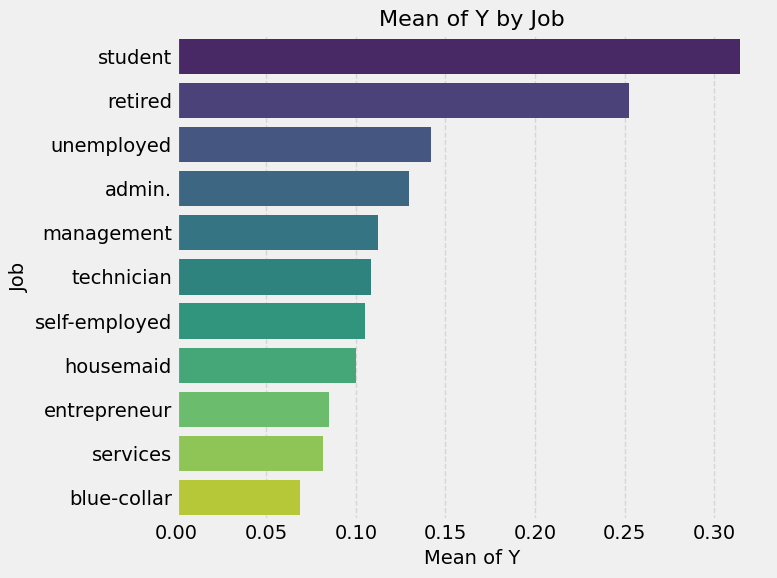

In [79]:
# Group by 'job' and calculate the mean of 'y'
job_means = df.groupby('job')['y'].mean().reset_index()

# Sort the DataFrame by the mean of 'y' in descending order
job_means = job_means.sort_values(by='y', ascending=False)

# Create the bar plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='y', y='job', data=job_means, palette='viridis')
plt.title('Mean of Y by Job', fontsize=16)
plt.xlabel('Mean of Y', fontsize=14)
plt.ylabel('Job', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

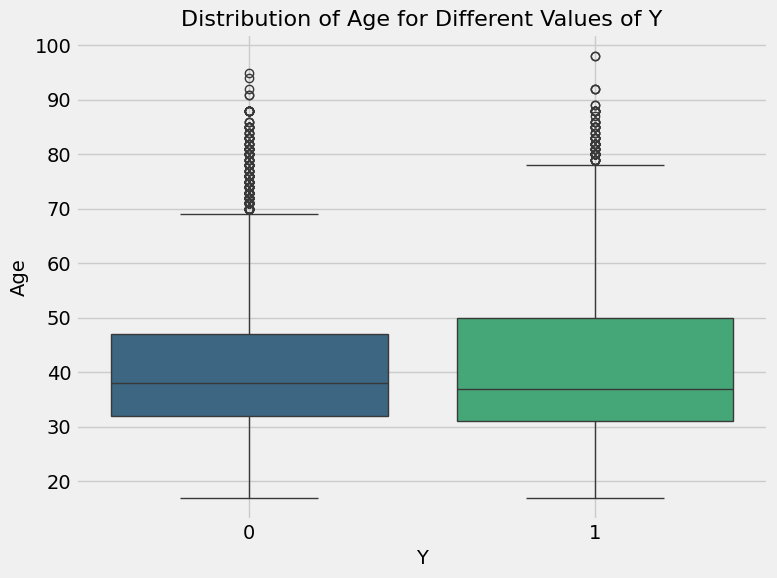

In [80]:
# Create a box plot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='age', data=df, palette='viridis')
plt.title('Distribution of Age for Different Values of Y', fontsize=16)
plt.xlabel('Y', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature Engineering

In [55]:
# Select columns 1 to 7 and Y column for Target
selected_columns = df.columns[0:7].tolist() + ['y']
df_selected = df[selected_columns]

In [56]:
# Check for missing values
print(df_selected.isnull().sum())

age             0
job           330
marital        80
education    1730
default      8596
housing       990
loan          990
y               0
dtype: int64


In [57]:
# Drop rows with missing values and reset the index
df_selected = df_selected.dropna().reset_index(drop=True)

In [58]:
# review selected columns
df_selected.head()

,age,job,marital,education,default,housing,loan,y
0,56,housemaid,married,basic.4y,no,no,no,0
1,37,services,married,high.school,no,yes,no,0
2,40,admin.,married,basic.6y,no,no,no,0
3,56,services,married,high.school,no,no,yes,0
4,59,admin.,married,professional.course,no,no,no,0


In [59]:
# Define the categorical and numerical columns
categorical_cols = df_selected.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_selected.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Ensure 'y' is not in the lists of columns to be transformed (this step was necessary as I kept getting an error otherwise)
if 'y' in categorical_cols:
    categorical_cols.remove('y')
if 'y' in numerical_cols:
    numerical_cols.remove('y')

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Separate features and target
X = df_selected.drop('y', axis=1)
y = df_selected['y']

# Print X and y to ensure they look good
print("Features (X):")
print(X.head())
print("\nTarget (y):")
print(y.head())

Features (X):
   age        job  marital            education default housing loan
0   56  housemaid  married             basic.4y      no      no   no
1   37   services  married          high.school      no     yes   no
2   40     admin.  married             basic.6y      no      no   no
3   56   services  married          high.school      no      no  yes
4   59     admin.  married  professional.course      no      no   no

Target (y):
0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64


In [60]:
# Apply the transformations
X_transformed = preprocessor.fit_transform(X)

# Check the shape of the transformed data
print(f"Shape of X_transformed: {X_transformed.shape}")

# Generate column names from preprocessor
column_names = preprocessor.get_feature_names_out()

# Check the number of feature names
print(f"Number of feature names: {len(column_names)}")
print(f"Feature names: {column_names}")


Shape of X_transformed: (30478, 28)
Number of feature names: 28
Feature names: ['num__age' 'cat__job_admin.' 'cat__job_blue-collar'
 'cat__job_entrepreneur' 'cat__job_housemaid' 'cat__job_management'
 'cat__job_retired' 'cat__job_self-employed' 'cat__job_services'
 'cat__job_student' 'cat__job_technician' 'cat__job_unemployed'
 'cat__marital_divorced' 'cat__marital_married' 'cat__marital_single'
 'cat__education_basic.4y' 'cat__education_basic.6y'
 'cat__education_basic.9y' 'cat__education_high.school'
 'cat__education_illiterate' 'cat__education_professional.course'
 'cat__education_university.degree' 'cat__default_no' 'cat__default_yes'
 'cat__housing_no' 'cat__housing_yes' 'cat__loan_no' 'cat__loan_yes']


In [61]:
# Apply StandardScaler to numerical columns
numerical_transformer = StandardScaler()
X_num_transformed = numerical_transformer.fit_transform(X[numerical_cols])

# Check the shape and data
print("Numerical Columns Transformed Shape:", X_num_transformed.shape)
print("Numerical Columns Transformed Data (first 5 rows):\n", X_num_transformed[:5])

Numerical Columns Transformed Shape: (30478, 1)
Numerical Columns Transformed Data (first 5 rows):
 [[ 1.64240809]
 [-0.19643635]
 [ 0.09390751]
 [ 1.64240809]
 [ 1.93275195]]


In [62]:
# Apply OneHotEncoder to categorical columns
categorical_transformer = OneHotEncoder()
X_cat_transformed = categorical_transformer.fit_transform(X[categorical_cols]).toarray()

# Check the shape and data
print("Categorical Columns Transformed Shape:", X_cat_transformed.shape)
print("Categorical Columns Transformed Data (first 5 rows):\n", X_cat_transformed[:5])

Categorical Columns Transformed Shape: (30478, 27)
Categorical Columns Transformed Data (first 5 rows):
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.
  0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
  0. 1. 0.]]


In [63]:
# Combine numerical and categorical transformed columns
X_transformed_combined = np.hstack((X_num_transformed, X_cat_transformed))

# Check the shape of combined data
print("Combined Transformed Shape:", X_transformed_combined.shape)


Combined Transformed Shape: (30478, 28)


In [64]:
# Generate column names for categorical features after one-hot encoding
categorical_feature_names = categorical_transformer.get_feature_names_out(categorical_cols)

# Combine numerical and categorical feature names
all_feature_names = numerical_cols + list(categorical_feature_names)

# Create DataFrame with transformed features
df_clean = pd.DataFrame(X_transformed_combined, columns=all_feature_names)

# Add the target column back to df_clean
df_clean['y'] = y.reset_index(drop=True)

# Inspect the cleaned DataFrame
print(df_clean.head())
print("Data preparation completed. The cleaned data is stored in 'df_clean'.")


        age  job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
0  1.642408         0.0              0.0               0.0            1.0   
1 -0.196436         0.0              0.0               0.0            0.0   
2  0.093908         1.0              0.0               0.0            0.0   
3  1.642408         0.0              0.0               0.0            0.0   
4  1.932752         1.0              0.0               0.0            0.0   

   job_management  job_retired  job_self-employed  job_services  job_student  \
0             0.0          0.0                0.0           0.0          0.0   
1             0.0          0.0                0.0           1.0          0.0   
2             0.0          0.0                0.0           0.0          0.0   
3             0.0          0.0                0.0           1.0          0.0   
4             0.0          0.0                0.0           0.0          0.0   

   ...  education_illiterate  education_professional.cou

In [65]:
# review df_clean
df_clean.head()

,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,education_illiterate,education_professional.course,education_university.degree,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,y
0,1.642408,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
1,-0.196436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0
2,0.093908,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
3,1.642408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0
4,1.932752,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0


### Split the Data into Train/Test Datasets

In [66]:
# Separate features and target
X = df_clean.drop('y', axis=1)
y = df_clean['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inspect the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (24382, 28)
X_test shape: (6096, 28)
y_train shape: (24382,)
y_test shape: (6096,)


### Scaling Numerical Columns

In [67]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Print final shapes
print(f"Final training set shape: {X_train.shape}")
print(f"Final test set shape: {X_test.shape}")


Final training set shape: (24382, 28)
Final test set shape: (6096, 28)


### One-Hot Encoding

In [68]:
# Select categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the training data and transform both training and testing data
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# Convert the encoded columns back to DataFrame
X_train_cat_df = pd.DataFrame(X_train_cat, columns=encoder.get_feature_names_out(categorical_cols))
X_test_cat_df = pd.DataFrame(X_test_cat, columns=encoder.get_feature_names_out(categorical_cols))

# Reset the index to ensure alignment
X_train_cat_df.reset_index(drop=True, inplace=True)
X_test_cat_df.reset_index(drop=True, inplace=True)

# Drop the original categorical columns from the training and testing sets
X_train.drop(categorical_cols, axis=1, inplace=True)
X_test.drop(categorical_cols, axis=1, inplace=True)

# Concatenate the encoded columns back to the original datasets
X_train = pd.concat([X_train.reset_index(drop=True), X_train_cat_df], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_cat_df], axis=1)

# Inspect the transformed training set
print(X_train.head())
print(X_test.head())


        age  job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
0 -0.000477         0.0              0.0               0.0            0.0   
1 -0.097430         0.0              0.0               0.0            0.0   
2  2.326389         0.0              0.0               0.0            0.0   
3 -1.842579         0.0              1.0               0.0            0.0   
4 -0.582194         0.0              1.0               0.0            0.0   

   job_management  job_retired  job_self-employed  job_services  job_student  \
0             1.0          0.0                0.0           0.0          0.0   
1             0.0          0.0                0.0           0.0          0.0   
2             0.0          1.0                0.0           0.0          0.0   
3             0.0          0.0                0.0           0.0          0.0   
4             0.0          0.0                0.0           0.0          0.0   

   ...  education_high.school  education_illiterate  \
0

### Building A Baseline Model with Dummy Classifier

In [69]:
# Initialize the DummyClassifier with the most-frequent strategy
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)

# Fit the DummyClassifier on the training data
dummy_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dummy = dummy_clf.predict(X_test)

# Evaluate the performance of the DummyClassifier
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
conf_matrix_dummy = confusion_matrix(y_test, y_pred_dummy)
class_report_dummy = classification_report(y_test, y_pred_dummy)

print("Dummy Classifier Performance:")
print(f"Accuracy: {accuracy_dummy}")
print("Confusion Matrix:\n", conf_matrix_dummy)
print("Classification Report:\n", class_report_dummy)

Dummy Classifier Performance:
Accuracy: 0.8708989501312336
Confusion Matrix:
 [[5309    0]
 [ 787    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      5309
           1       0.00      0.00      0.00       787

    accuracy                           0.87      6096
   macro avg       0.44      0.50      0.47      6096
weighted avg       0.76      0.87      0.81      6096



### Build a Logistic Regression Model

In [70]:
# Initialize the LogisticRegression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate the performance of the LogisticRegression model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
class_report_log_reg = classification_report(y_test, y_pred_log_reg)

print("Logistic Regression Model Performance:")
print(f"Accuracy: {accuracy_log_reg}")
print("Confusion Matrix:\n", conf_matrix_log_reg)
print("Classification Report:\n", class_report_log_reg)

Logistic Regression Model Performance:
Accuracy: 0.8708989501312336
Confusion Matrix:
 [[5309    0]
 [ 787    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      5309
           1       0.00      0.00      0.00       787

    accuracy                           0.87      6096
   macro avg       0.44      0.50      0.47      6096
weighted avg       0.76      0.87      0.81      6096



### Model Comparisons

Building Logistic Regression, KNN, Decision Tree, and SVM models with default settings and comapring their accuracy scores and training times.

In [71]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}
# Prepare a list to store the results
results = []

# Iterate over models
for model_name, model in models.items():
    # Record the start time
    start_time = time.time()
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Record the end time
    end_time = time.time()
    
    # Calculate train and test accuracy
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    # Calculate training time
    train_time = end_time - start_time
    
    # Append results to the list
    results.append({
        'Model': model_name,
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    })

# Convert results list to a DataFrame
results_df = pd.DataFrame(results)

print(results_df)


                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression    0.036522        0.874046       0.870899
1                  KNN    0.001619        0.876630       0.860072
2        Decision Tree    0.041887        0.901772       0.850230
3                  SVM   10.915526        0.874046       0.870899


### Improving the Models

Hyperparameter tuning and grid search for the most optimal results of our base models above. 

In [73]:
# Define hyperparameter grids
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}
param_grid_knn = {'n_neighbors': [3, 5, 7]}
param_grid_dt = {'max_depth': [3, 5, 7], 'criterion': ['gini', 'entropy']}
param_grid_svm = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf', 'linear']}

# Initialize GridSearchCV for each model
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=3, scoring='f1', n_jobs=-1)
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='f1', n_jobs=-1)
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=3, scoring='f1', n_jobs=-1)
grid_search_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, scoring='f1', n_jobs=-1)

# Fit GridSearchCV
grid_search_lr.fit(X_train, y_train)
grid_search_knn.fit(X_train, y_train)
grid_search_dt.fit(X_train, y_train)
grid_search_svm.fit(X_train, y_train)

# Get best estimators and parameters
best_lr = grid_search_lr.best_estimator_
best_knn = grid_search_knn.best_estimator_
best_dt = grid_search_dt.best_estimator_
best_svm = grid_search_svm.best_estimator_

best_params_lr = grid_search_lr.best_params_
best_params_knn = grid_search_knn.best_params_
best_params_dt = grid_search_dt.best_params_
best_params_svm = grid_search_svm.best_params_

# Evaluate best models on test data
best_models = {
    'Logistic Regression': best_lr,
    'KNN': best_knn,
    'Decision Tree': best_dt,
    'SVM': best_svm
}

best_params = {
    'Logistic Regression': best_params_lr,
    'KNN': best_params_knn,
    'Decision Tree': best_params_dt,
    'SVM': best_params_svm
}

# Prepare a list to store the results
results = []

# Iterate over best models
for model_name, model in best_models.items():
    # Record the start time
    start_time = time.time()
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Record the end time
    end_time = time.time()
    
    # Calculate train and test accuracy
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    # Calculate the training time in seconds
    train_time = (end_time - start_time) 

    # Append the results to the list
    results.append({
        'Model': model_name,
        'Train Time (s)': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Best Params': best_params[model_name]
    })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

                 Model  Train Time (s)  Train Accuracy  Test Accuracy  \
0  Logistic Regression        0.022495        0.874046       0.870899   
1                  KNN        0.002848        0.876671       0.842520   
2        Decision Tree        0.022439        0.875728       0.870899   
3                  SVM       31.239822        0.882700       0.867618   

                                         Best Params  
0  {'C': 100, 'penalty': 'l1', 'solver': 'libline...  
1                                 {'n_neighbors': 3}  
2           {'criterion': 'entropy', 'max_depth': 7}  
3             {'C': 10, 'gamma': 1, 'kernel': 'rbf'}  


### Examining Top Features from the Decision Tree Model

In [81]:
# Get the feature importances from the best Decision Tree model
feature_importances = best_dt.feature_importances_

# Create a DataFrame to hold the feature names and their importance values
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance values in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print(features_df.head(10))


                          Feature  Importance
0                             age    0.518197
9                     job_student    0.171793
21    education_university.degree    0.101527
15             education_basic.4y    0.035626
2                 job_blue-collar    0.030376
11                 job_unemployed    0.025646
14                 marital_single    0.021512
13                marital_married    0.014517
12               marital_divorced    0.013913
20  education_professional.course    0.011334


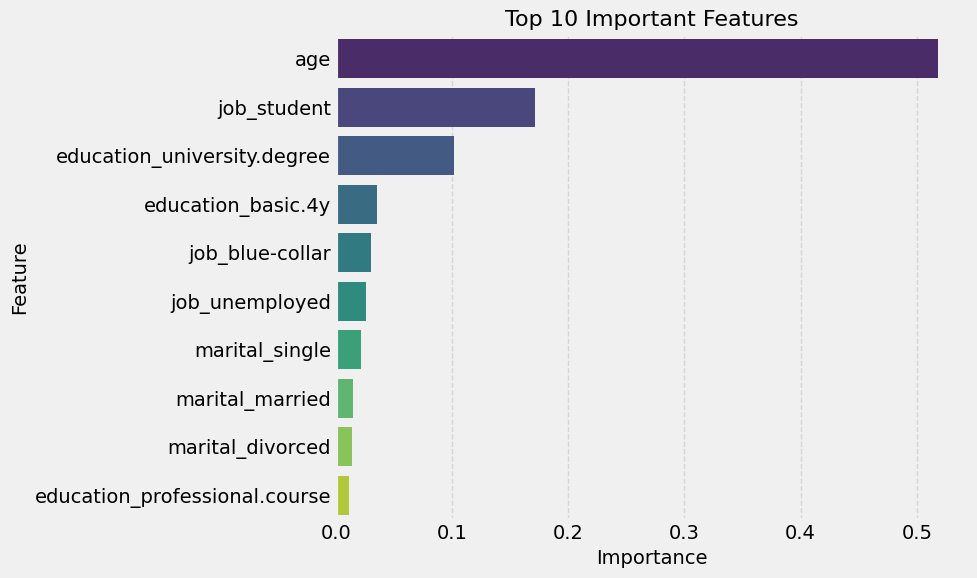

In [84]:
# Get the feature importances from the best Decision Tree model
feature_importances = best_dt.feature_importances_

# Create a DataFrame to hold the feature names and their importance values
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance values in descending order
features_df = features_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 most important features 
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title('Top 10 Important Features', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Summary of Model Performance Findings:

- Logistic Regression: Although Logistic Regression showed good performance, it faced convergence issues. Test Accuracy: 87.09% 
- KNN: Quick to train but slightly lower test accuracy compared to Logistic Regression and Decision Tree. Test Accuracy: 84.25%
- Decision Tree: Performed similarly well as Logistic Regressioncy. Despite the SVM model achieving slightly higher accuracy, the Decision Tree's interpretability makes it valuable for understanding feature importance. Test Accuracy: 87.09%
- SVM: Highest training accuracy but also extremely long training time, indicating it can handle complex decision boundaries well, however the minimal improvement in performance is generally not worth the extra compute time. Test Accuracy: 86.76%

### Most Important Features from Decision Tree model:

- Age: The most significant feature with an importance of 0.518197. Older clients are more likely to respond positively to marketing campaigns.
- Job (Student): With an importance of 0.171793, being a student significantly impacts the likelihood of a positive response.
- Education (University Degree): Higher education levels, such as holding a university degree, have a notable impact on the response, with an importance of 0.101527.
- Other Important Features:
-- Basic Education (4 years): 0.035626
-- Job (Blue-collar): 0.030376
-- Job (Unemployed): 0.025646

### Recommendations and Next Steps:

1) Targeted Marketing Strategies and Personalized Communication:

- Age: Given the high importance of age, marketing campaigns should be tailored to different age groups. Older clients, in particular, should be targeted with campaigns that address their specific needs and preferences.
- Students and Educated Clients: Special attention should be given to students and clients with higher education levels, such as university graduates. These groups show significant predictive importance and should be targeted with customized marketing messages.

2) Feature Engineering and Further Model Tuning:

- Job and Education Levels: Further feature engineering could uncover additional valuable predictors. For example, exploring interactions between job types and education levels may provide deeper insights into client behaviors.
- Handling Convergence Issues: For Logistic Regression, increasing the max_iter parameter or using a different solver like 'saga' could help achieve convergence.
- Decision Tree: Given its high accuracy and interpretability, further tuning of the Decision Tree model's parameters, such as max_depth and criterion, could yield even better results.
- Adjusting Performance Metrics: Precision, Recall, and F1 Score could be explored as additional metrics, especially since there is a class imbalance, to better capture the model's performance.
